In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
import torch.backends.cudnn as cudnn
import os
#path_data = 'MyDrive/Dati CNN/'
#path_mount = '/content/drive/'

#from google.colab import drive
#drive.mount('/content/drive')

#subject = 'CNN1'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [3]:
input_dim = 28*28
hidden_dim = 10
out_dim = 10


class ConvolutionalNetwork(nn.Module):

  def __init__(self, input_dim, out_dim):

    super(ConvolutionalNetwork, self).__init__()
    # Convolutional Neural Network Layer
    self.convolutaional_neural_network_layers = nn.Sequential(
                            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(3,3), padding=1, stride=1), # (N, 1, 28, 28)
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=(3,3), padding=1, stride=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

    # Linear layer
    self.linear_layers = nn.Sequential(
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=5*7*7, out_features=out_dim),
        )

    #Softmax
    self.soft = nn.Softmax(dim=1)


  # Defining the forward pass
  def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the linear layer
        x = self.linear_layers(x)

        x = self.soft(x)

        return x

In [4]:
model = ConvolutionalNetwork(input_dim, out_dim).to(device)

if device.type != "cpu":
  model = torch.compile(model)
else:
  model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)


In [6]:
loss_function = nn.CrossEntropyLoss()

In [8]:
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy

def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

  acc_train, acc_test = 0, 0

  with torch.no_grad():

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

      out = model(x_train).squeeze()
      acc_train += accuracy(out, y_train)

    for x_test, y_test in test_loader:

      x_test, y_test = x_test.to(device), y_test.to(device)

      out = model(x_test).squeeze()
      acc_test += accuracy(out, y_test)

    acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

  return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100

def train(model, x, y):

  out = model(x)
  loss = loss_function(out.squeeze(), y)

  optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
  optimizer.step()
  return float(loss)

if device.type != "cpu":
  accuracy = torch.compile(accuracy)
  train = torch.compile(train)
else:
  accuracy = torch.compile(accuracy, mode = "max-autotune-no-cudagraphs", dynamic=True)
  train = torch.compile(train, mode = "max-autotune-no-cudagraphs", dynamic=True)


In [9]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)


In [10]:
checkpoint_dir = "/content/.checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [11]:
n_train = 8000
n_test = 350
ratio = 50

batch_size_train = 16
batch_size_test = 32

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)


In [12]:
ACCURACY_matrix = []
TrainLOSS_matrix = []
TrainACCURACY_matrix = []

train_losses = []
train_accuracies = []
test_accuracies = []

import torch._dynamo
torch._dynamo.config.suppress_errors = True


for i in range (1,ratio+1):
  ## TRAIN SET

  n_train_loop = int(n_train * i / ratio)

  #batch_size_train_loop = int(batch_size_train * i / ratio)
  dataset_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                          transform=transform)
  dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]

  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train,
                                              shuffle = True,  drop_last = True)
  EPOCHS = 101


  #os.environ['TORCHDYNAMO_CACHE_SIZE_LIMIT'] = '800'
  #os.environ['TORCH_LOGS'] = 'recompiles'

  torch._dynamo.config.cache_size_limit = 800
  model = ConvolutionalNetwork(input_dim, out_dim).to(device)
  loss_function = nn.CrossEntropyLoss()



  learning_rate = 0.1
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
  early_stopping = EarlyStopping(patience=4, verbose=True, path='/content/.checkpoints/model_checkpoint.pt')
  for epoch in range(1,EPOCHS+1):

    train_loss = 0

    ## TRAIN STEP

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)


      loss = train(model, x_train, y_train)

      train_loss += loss

    train_loss /= len(train_loader)                    # we divide by the number of batches
    train_losses.append(train_loss)

    train_acc, test_acc = evaluate(model, train_loader, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if epoch % 10 == 0:
      print("Epoch:", epoch, "Loss:", float(train_loss), "data:", len(dataset_train.data), "train_acc", train_acc, "test_acc", test_acc)

    early_stopping(train_loss, model)
    if early_stopping.early_stop:
      print("Early stopping triggered.")

      for i in range(0, (EPOCHS - len(test_accuracies))):
        test_accuracies.append(0)
        train_losses.append(0)
        train_accuracies.append(0)

      # Save in ACCURACY_matrix
      ACCURACY_matrix.append(test_accuracies)
      TrainLOSS_matrix.append(train_losses)
      TrainACCURACY_matrix.append(train_accuracies)

      # Delate the test_accuracies list
      test_accuracies = []
      train_losses = []
      train_accuracies = []
      break

    if epoch == 100:

      # Save in ACCURACY_matrix
      ACCURACY_matrix.append(test_accuracies)
      TrainLOSS_matrix.append(train_losses)
      TrainACCURACY_matrix.append(train_accuracies)
      # Delate the test_accuracies list
      test_accuracies = []
      train_losses = []
      train_accuracies = []

W0609 10:37:32.270000 11324 torch\_dynamo\convert_frame.py:824] WON'T CONVERT train C:\Users\39370\AppData\Local\Temp\ipykernel_14184\721347345.py line 36 
W0609 10:37:32.270000 11324 torch\_dynamo\convert_frame.py:824] due to: 
W0609 10:37:32.270000 11324 torch\_dynamo\convert_frame.py:824] Traceback (most recent call last):
W0609 10:37:32.270000 11324 torch\_dynamo\convert_frame.py:824]   File "C:\ProgramData\anaconda3\Lib\site-packages\torch\_dynamo\convert_frame.py", line 786, in _convert_frame
W0609 10:37:32.270000 11324 torch\_dynamo\convert_frame.py:824]     result = inner_convert(
W0609 10:37:32.270000 11324 torch\_dynamo\convert_frame.py:824]              ^^^^^^^^^^^^^^
W0609 10:37:32.270000 11324 torch\_dynamo\convert_frame.py:824]   File "C:\ProgramData\anaconda3\Lib\site-packages\torch\_dynamo\convert_frame.py", line 400, in _convert_frame_assert
W0609 10:37:32.270000 11324 torch\_dynamo\convert_frame.py:824]     return _compile(
W0609 10:37:32.270000 11324 torch\_dynamo\co

Epoch: 10 Loss: 2.0258211970329283 data: 160 train_acc 43.75 test_acc 32.91666805744171
Epochs without improvement: 1
Epoch: 20 Loss: 1.8424348950386047 data: 160 train_acc 67.5000011920929 test_acc 47.708332538604736
Epochs without improvement: 2
Epochs without improvement: 1
Epochs without improvement: 2
Epochs without improvement: 1
Epochs without improvement: 2
Epoch: 30 Loss: 1.7847993612289428 data: 160 train_acc 70.6250011920929 test_acc 54.26136255264282
Epochs without improvement: 1
Epochs without improvement: 1
Epochs without improvement: 1
Epochs without improvement: 1
Epochs without improvement: 1
Epochs without improvement: 2
Epoch: 40 Loss: 1.7289924502372742 data: 160 train_acc 76.2499988079071 test_acc 59.98106002807617
Epochs without improvement: 3
Epochs without improvement: 1
Epochs without improvement: 1
Epochs without improvement: 1
Epoch: 50 Loss: 1.6540009379386902 data: 160 train_acc 80.0000011920929 test_acc 66.53409004211426
Epochs without improvement: 1
Epoch

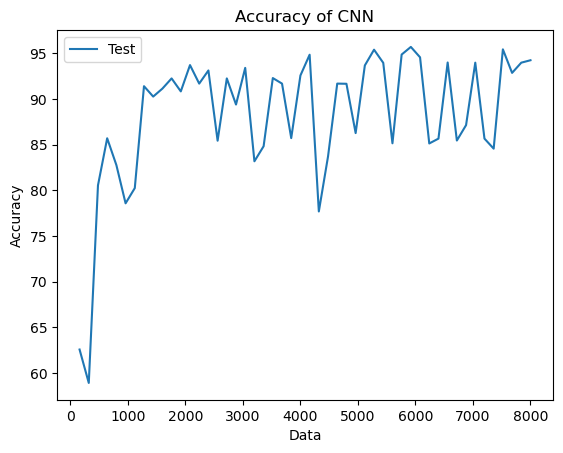

In [18]:
# Function to get the last non-zero value in a list
def last_non_zero(lst):
    i = 0
    for item in lst:
        if item == 0:
            return lst[i - 1]
        i += 1
    return None

# Function to calculate the moving average
def moving_average(values, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(values, weights, mode='valid')

# Calculate moving average
#window_size = 3
#moving_avg = moving_average(last_non_zero_values, window_size)

# Extract last non-zero values from each list
last_non_zero_values = [last_non_zero(sublist) for sublist in ACCURACY_matrix]

# The size of the dataset
data = [n_train * i/ratio for i in range(1, ratio + 1)]
data_mavg = data[window_size - 1:]
# Plot the moving average
#plt.plot(data_mavg, moving_avg, label=f'Moving Average (window={window_size})', marker='x')

# Plot the values
plt.plot(data, last_non_zero_values, label = "Test")
plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title('Accuracy of CNN')
plt.legend()
plt.show()

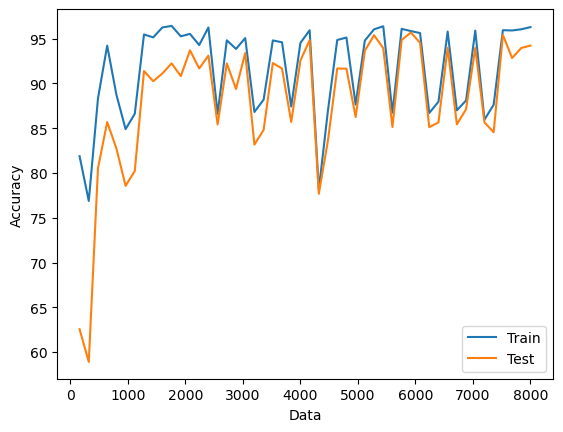

In [20]:
data = [n_train * i/ratio for i in range(1, ratio+1)]
# Extract last non-zero values from each list
last_non_zero_values_train = [last_non_zero(sub) for sub in TrainACCURACY_matrix]
last_non_zero_values_test = [last_non_zero(sublist) for sublist in ACCURACY_matrix]

plt.plot(data, last_non_zero_values_train, label = "Train")
plt.plot(data, last_non_zero_values_test, label = "Test")

plt.xlabel("Data")
plt.ylabel("Accuracy")


plt.legend()

plt.show()

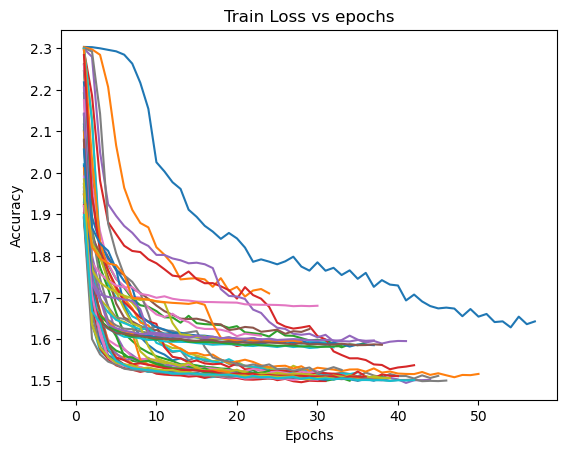

In [22]:
TrainLOSS_matrix[46]

def last_non_zero_sublst(lst):
    i = 0
    for item in lst:
        if item == 0:
            return lst[:i - 1]
        i += 1
    return None

# Extract last non-zero values from each list
for i in range(len(TrainLOSS_matrix)):
    last_non_zero_values = last_non_zero_sublst(TrainLOSS_matrix[i])
    plt.plot(range(1, len(last_non_zero_values) + 1), last_non_zero_values)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Train Loss vs epochs')
plt.show()

In [24]:
import numpy as np
result_dir = 'result'
os.makedirs(result_dir, exist_ok=True)

file_name1 = 'TrainLOSS_matrix_MNIST_normal_CNN.npy'
np.save(os.path.join(result_dir, file_name1), TrainLOSS_matrix)

file_name2 = 'ACCURACY_matrix_MNIST_normal_CNN.npy'
np.save(os.path.join(result_dir, file_name2), ACCURACY_matrix)

file_name3 = 'TrainACCURACY_matrix_MNIST_normal_CNN.npy'
np.save(os.path.join(result_dir, file_name2), TrainACCURACY_matrix)

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in test_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.95 0.03 0.   0.   0.   0.03 0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.02 0.   0.   0.  ]
 [0.   0.   0.   0.03 0.   0.97 0.   0.   0.   0.  ]
 [0.04 0.   0.   0.   0.   0.   0.96 0.   0.   0.  ]
 [0.   0.   0.   0.03 0.   0.   0.   0.97 0.   0.  ]
 [0.   0.   0.04 0.   0.   0.   0.   0.   0.96 0.  ]
 [0.   0.   0.   0.03 0.03 0.05 0.   0.   0.03 0.87]]


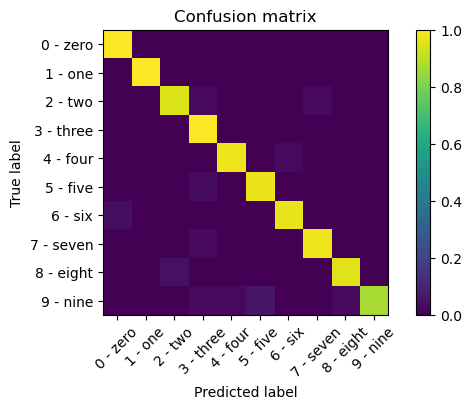

In [27]:
classes =dataset_test.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

NameError: name 'test_accuracies' is not defined